<a href="https://colab.research.google.com/github/eeuunnjjiii/kagglestudy/blob/main/%20Credit%20Card%20/%5B1st_kernel%5D_In_depth_skewed_data_classif_(93_recall_acc_now).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunjijeong","key":"29fdf1c9b4bee7ef56c5520fc84d41dc"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Loading the dataset

In [86]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Checking the target classes

Text(0, 0.5, 'Frequency')

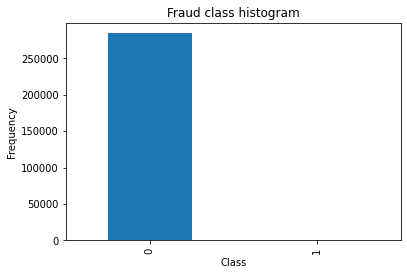

In [87]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

## 엄청 불균형한 데이터
- 기존 분류에서 사용하듯 accuracy로만 측정하면 부정확함 (1을 전부 0으로 분류해도 높은 accuracy)

## 불균형 문제 해결법
- 더 많은 데이터 모으기? 좋은 방법이지만 이 케이스에는 사용 못함
- 성능 평가지표 변경
  - Precision, Recall을 함께 계산
  - F1 score (precison과 recall의 가중평균)
  - Kappa 이용 (불균형 데이터에서 정규화된 분류 정확도)
  - ROC curves (민감도, 특이도 비율)

- 데이터셋 리샘플링
  - 50대 50으로 재가공
  - 적은 데이터를 오버샘플링 하거나 많은 데이터를 언더샘플링

# Setting our input and target variables + resampling

In [88]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) ## 특성 하나만 스케일링 할 때
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [89]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [90]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select 'x' number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_noraml_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print('Percentage of normal transactions: ', len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print('Percentage of fraud transactions: ', len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print('Total number of transacttions in resampled data: ', len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transacttions in resampled data:  984


# Splittting data into train and test set. Cross validatiton will be used when calculatting accuracies.

In [91]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Number transactions train dataset: ', len(X_train))
print('Number transactions test dataset: ', len(X_test))
print('Total number of transactions: ', len(X_train) + len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print("")
print('Number transactions train dataset: ', len(X_train_undersample))
print('Number transactions test dataset: ', len(X_test_undersample))
print('Total number of transactions: ', len(X_train_undersample) + len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


# Logistic regression classifier - Undersampled data

- 실제 양성중 양성으로 예측된 비율을 나타내는 Recall(재현율)을 메인 성능지표로 사용

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [93]:
def printing_Kfold_scores(x_train_data, y_train_data):
  fold = KFold(5, shuffle=False)

  # Different C parameters
  c_param_range = [0.01, 0.1, 1, 10, 100]

  result_table = pd.DataFrame(index=range(len(c_param_range), 2), columns = ['C_parameter', 'Mean recall score'])
  result_table['C_parameter'] = c_param_range

  # the K-fold will give 2 lists
  j = 0
  for c_param in c_param_range:
    print('-'*8)
    print('C parameter: ', c_param)
    print('-'*8)
    print('')

    recall_accs = []
    k = 0
    for train_index, test_index in fold.split(x_train_data):

      # Call the logistic regression model with a certain C parameter
      lr = LogisticRegression(C = c_param)
      
      lr.fit(x_train_data.iloc[train_index,:], y_train_data.iloc[train_index, :].values.ravel())

      # Predict values using the test indices in the training data
      y_pred_undersample = lr.predict(x_train_data.iloc[test_index,:].values)
      
      
      # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
      recall_acc = recall_score(y_train_data.iloc[test_index, :].values, y_pred_undersample)
      recall_accs.append(recall_acc)
      print('Iteration ', k, ': recall score = ', recall_acc)
      k += 1

    # The mean value of those recall scores is the metric we want to save and get hold of.
    result_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
    j += 1
    print('')
    print('Mean recall score', np.mean(recall_accs))

  best_c = result_table.loc[pd.to_numeric(result_table['Mean recall score']).idxmax()]['C_parameter']

  # Finally, we can check which C parameter is the best amongst the chosen.
  print('*********************************************************************************')
  print('Best model to choose from cross validation is with C parameter = ', best_c)
  print('*********************************************************************************')
  
  return best_c

In [94]:
best_c = printing_Kfold_scores(X_train_undersample, y_train_undersample)

--------
C parameter:  0.01
--------

Iteration  0 : recall score =  0.821917808219178
Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.8983050847457628
Iteration  3 : recall score =  0.918918918918919
Iteration  4 : recall score =  0.8939393939393939

Mean recall score 0.8764792548632808
--------
C parameter:  0.1
--------

Iteration  0 : recall score =  0.8356164383561644
Iteration  1 : recall score =  0.863013698630137
Iteration  2 : recall score =  0.9491525423728814
Iteration  3 : recall score =  0.9324324324324325
Iteration  4 : recall score =  0.9090909090909091

Mean recall score 0.8978612041765048
--------
C parameter:  1
--------

Iteration  0 : recall score =  0.8493150684931506
Iteration  1 : recall score =  0.8767123287671232
Iteration  2 : recall score =  0.9830508474576272
Iteration  3 : recall score =  0.9459459459459459
Iteration  4 : recall score =  0.9090909090909091

Mean recall score 0.9128230199509512
--------
C parameter:  10
---

# Create a function to plot a fancy confusion matrix

In [95]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied setting 'normalize=True'"""

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  if normalize :
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## Predictions on test and plotting confusion matrix

Recall metric in the testing dataset:  0.9183673469387755


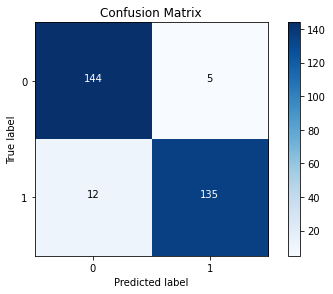

In [96]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train_undersample, y_train_undersample.values.ravel()) ##1차원 배열로 펴줌
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ', cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))

# plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

# Apply the model we fitted and test it on the whole data

Recall metric in the testing dataset:  0.9455782312925171


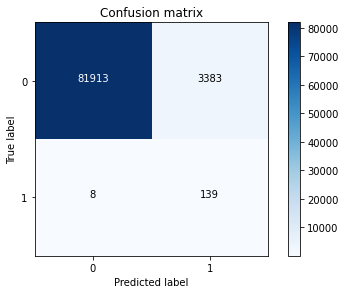

In [97]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Plotting ROC curve and Precision-Recall curve

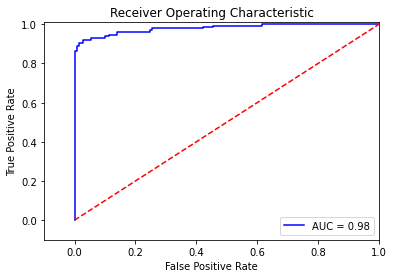

In [98]:
# ROC Curve
l = LogisticRegression(C=best_c)
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)


# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
best_c = printing_Kfold_scores(X_train,y_train)

--------
C parameter:  0.01
--------

Iteration  0 : recall score =  0.5373134328358209
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.6666666666666666
Iteration  3 : recall score =  0.6
Iteration  4 : recall score =  0.5

Mean recall score 0.5840836911333742
--------
C parameter:  0.1
--------

Iteration  0 : recall score =  0.5522388059701493
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.7166666666666667
Iteration  3 : recall score =  0.6153846153846154
Iteration  4 : recall score =  0.5625

Mean recall score 0.612645688837163
--------
C parameter:  1
--------

Iteration  0 : recall score =  0.5522388059701493
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.7333333333333333
Iteration  3 : recall score =  0.6153846153846154
Iteration  4 : recall score =  0.575

Mean recall score 0.6184790221704963
--------
C parameter:  10
--------

Iteration  0 : recall score =  0.5522388059701

Recall metric in the testing dataset:  0.6190476190476191


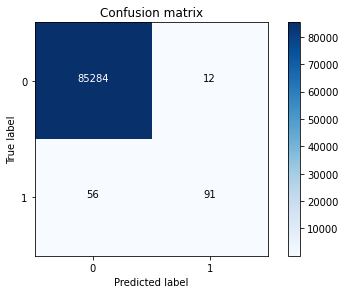

In [100]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train, y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test, y_pred_undersample)
np.set_printoptions(precision=2) ##소수점 두자리

print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Changing classification threshold

Recall metric in the testing dataset:  0.9591836734693877
Recall metric in the testing dataset:  0.9455782312925171
Recall metric in the testing dataset:  0.9387755102040817
Recall metric in the testing dataset:  0.9319727891156463
Recall metric in the testing dataset:  0.9115646258503401
Recall metric in the testing dataset:  0.9047619047619048
Recall metric in the testing dataset:  0.8843537414965986
Recall metric in the testing dataset:  0.8639455782312925
Recall metric in the testing dataset:  0.8639455782312925


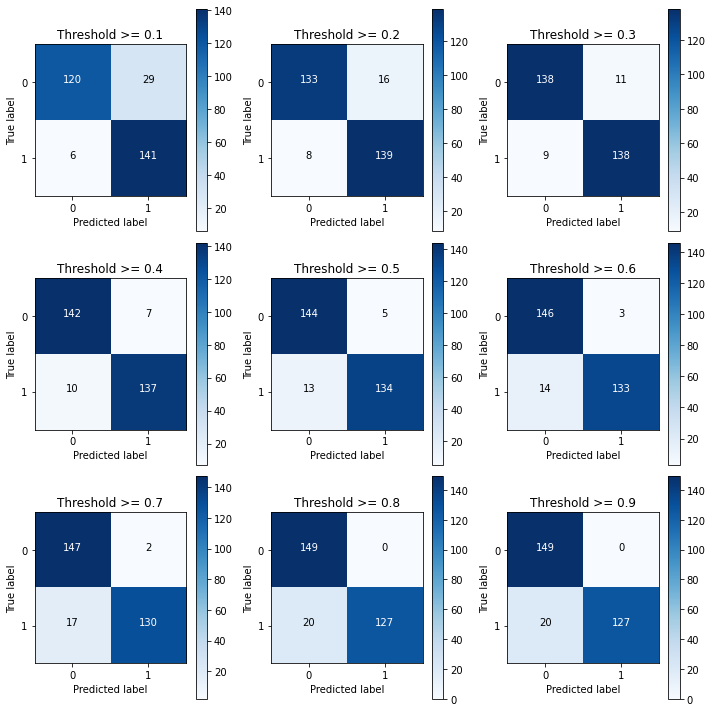

In [101]:
lr = LogisticRegression(C = 1.0)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10, 10))

j = 1
for i in thresholds :
  y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i

  plt.subplot(3, 3, j)
  j += 1

  cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
  np.set_printoptions(precision=2)

  print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

  # Plot non-normalized confusion matrix
  class_names = [0,1]
  plot_confusion_matrix(cnf_matrix
                        , classes=class_names
                        , title='Threshold >= %s'%i) 

- recall이 목표 성능지표이지만 전체 정확도도 고려해야함

# Investigate Precision-Recall curve and area under this curve

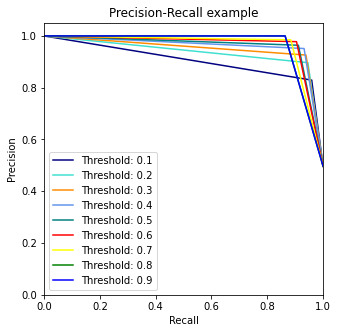

In [102]:
from itertools import cycle

lr = LogisticRegression(C=1.0)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5, 5))

j = 1
for i, color in zip(thresholds, colors):
  y_test_predictions_prob = y_pred_undersample_proba[:, 1] > i

  precision, recall, thresholds = precision_recall_curve(y_test_undersample, y_test_predictions_prob)

  plt.plot(recall, precision, color=color, label='Threshold: %s'%i)

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall example')
  plt.legend(loc="lower left")